In [1]:
import numpy as np
import ee
import matplotlib.pyplot as plt
%matplotlib inline
import tifffile as tiff
import zipfile
import os
import requests
import io
import random

In [2]:
ee.Initialize()

In [3]:
def unzip_url(img_url, tmp_directory = None):
    
    if tmp_directory == None:
        tmp_directory="./tmp/"+str(random.randrange(99999999))
    zip_filename = os.path.join(tmp_directory, 'zipped_tile.zip')

    if not os.path.exists(tmp_directory):
        os.makedirs(tmp_directory)

    filelist = [ f for f in os.listdir(tmp_directory)]
    for f in filelist:
        os.remove(os.path.join(tmp_directory, f))

    try:
        request = requests.get(img_url)
    except requests.ConnectionError as e:
        raise e

    if (request.status_code == 200):
        z = io.BytesIO(request.content)
        z = zipfile.ZipFile(z)
        z.extractall(tmp_directory)
        z.close()
        return tmp_directory
    elif (request.status_code == 400):
        print('Status code 400 (Bad Request). Possible problems:')
        print('You requested a band that was not available in every image')
        print('Some other unknown issue')
        raise ServerError('Status code 400')
    elif (request.status_code == 429):
        raise ServerError('Status code 429')
    else:
        raise ServerError('Status code ' + str(request.status_code))
    
    raise Exception('Unknown error in unzip_url() function')

In [4]:
def tif_at_region(geCollection, resolution, bands, geo_bounds, verbose=False):
    DEFAULT_MAP_NAME = 'map_section'
    gee_img = geCollection.filterBounds(geo_bounds).select(bands).mosaic()
    bands_string = [{'id': b} for b in bands]
    path=gee_img.getDownloadUrl({
            'name': DEFAULT_MAP_NAME,
            'scale': resolution,
            'crs': 'EPSG:4326',
            'bands': bands_string,
            'region': geo_bounds.getInfo()['coordinates']
    });
    
    if verbose:
        print(path)
    
    tif_location = unzip_url(path)
    tif_filename_object = {}
    for band in bands:
        tif_filename = DEFAULT_MAP_NAME+'.'+band+'.tif'
        tif_path = os.path.join(tif_location, tif_filename)
        tif_filename_object[band] = tif_path
    return tif_filename_object

In [5]:
def img_at_region(geCollection, resolution, bands, geo_bounds, verbose=False):
    tif_band_dictionary = tif_at_region(geCollection, resolution, bands, geo_bounds, verbose)
    img_band_dictionary = {}
    for k,v in tif_band_dictionary.items():
        img_band_dictionary[k] = tiff.imread(v)
    return img_band_dictionary

In [6]:
location_boundary = ee.Geometry.Rectangle([-74.48, 39.3893, -74.406, 39.3443])
tiles = img_at_region(ee.ImageCollection('USDA/NAIP/DOQQ'), 5, ['R','G','B'], location_boundary)

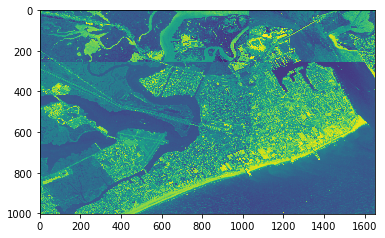

In [7]:
plt.imshow(tiles['R'])
plt.show()

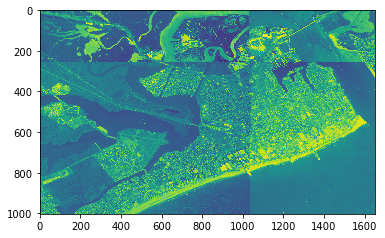

In [8]:
plt.imshow(tiles['G'])
plt.show()

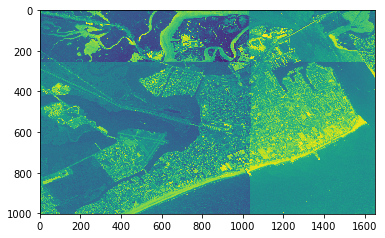

In [9]:
plt.imshow(tiles['B'])

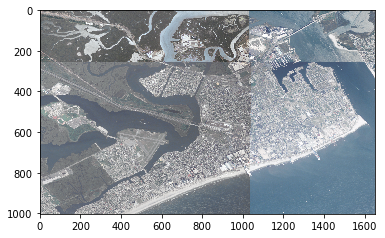

In [10]:
stacked_image = np.dstack((tiles['R'], tiles['G'], tiles['B']))
plt.imshow(stacked_image, cmap='flag')